In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import Imputer

import seaborn as sns

from pandas.plotting import scatter_matrix


from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor


from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

%matplotlib inline

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [15]:
#Separazione delle colonne secondo categorie
ID_col = ['Unnamed: 0',"Unnamed: 0.1", "STATION_ID","STATION_ID_2","STATION_ID_3","STATION_ID_4", 'KEY', 'KEY_2_x', 'KEY_2_y']
target_col = ["SPEED_AVG", 'SPEED_MAX','SPEED_MIN','SPEED_SD']
cat_col = ["EVENT_TYPE","WEATHER", 'TIME_INTERVAL']
time_col = ['DATETIME_UTC','START_DATETIME_UTC','END_DATETIME_UTC', "DATETIME_UTC_WEATHER"]
other_col = ['KM_START', 'KM_END']
num_col= list(set(list(df.columns))-set(ID_col)-set(target_col)-set(time_col)-set(cat_col))

In [16]:
#caricare il dataset riducendo le colonne numeriche da 64 a 32 bit
df = pd.read_csv('train.csv', dtype={col: np.float32 for col in num_col})
test = pd.read_csv('validation.csv', dtype={col: np.float32 for col in num_col})

In [17]:
df.head()


,Unnamed: 0.1.1,Unnamed: 0.1.1.1,EVENT_DETAIL,EVENT_TYPE,KEY,DATETIME_UTC,KM,SPEED_AVG,DISTANCE_FROM_POINT,LENGTH_KM,WEEK_DAY,TIME_INTERVAL,DELTA_TIME_FROM_START,EMERGENCY_LANE,LANES,ROAD_TYPE,TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE,WEATHER
0,858562.0,184264.0,1.0,Pavimentazione,319.0,2018-09-01 00:00:00,1750.0,165.729429,-430.0,-1.0,5.0,Night,56.099998,0.0,1.0,0.0,18.0,22.0,16.0,DebolePioggia
1,683924.0,4512385.0,9.0,Ostacolo_in_carreggiata,204.0,2018-09-01 00:00:00,709.0,184.128400,513.0,1.0,5.0,Night,26.200001,0.0,1.0,0.0,20.0,20.0,20.0,QuasiSereno
2,666792.0,4501571.0,9.0,Ostacolo_in_carreggiata,204.0,2018-09-01 00:00:00,211.0,238.816800,15.0,1.0,5.0,Night,26.200001,0.0,2.0,0.0,25.0,27.0,21.0,Foschia
3,702092.0,4502796.0,9.0,Ostacolo_in_carreggiata,204.0,2018-09-01 00:00:00,751.0,148.303512,555.0,1.0,5.0,Night,26.200001,0.0,1.0,0.0,20.0,20.0,20.0,QuasiSereno
4,697418.0,4507150.0,9.0,Ostacolo_in_carreggiata,204.0,2018-09-01 00:00:00,644.0,151.220769,448.0,1.0,5.0,Night,26.200001,0.0,1.0,0.0,20.0,26.0,20.0,DebolePioggia


In [18]:
df.describe()

,Unnamed: 0.1.1,Unnamed: 0.1.1.1,EVENT_DETAIL,KEY,KM,SPEED_AVG,DISTANCE_FROM_POINT,LENGTH_KM,WEEK_DAY,DELTA_TIME_FROM_START,EMERGENCY_LANE,LANES,ROAD_TYPE,TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE
count,7.836420e+05,783642.00,783129.000000,783642.000000,783642.000000,783642.000000,783642.000000,783642.000000,783642.000000,783642.000000,783642.000000,783642.000000,783642.000000,778856.000000,778856.000000,778856.000000
mean,5.273932e+05,5270594.50,18.341326,167.775290,988.667603,183.411600,-434.020203,0.415847,2.400110,37.558578,0.273931,1.689626,0.274634,19.163052,20.209644,16.034285
std,3.012763e+05,4384086.00,18.269377,159.130197,500.467834,35.105282,638.697937,26.579084,1.830725,21.651562,0.446986,0.765201,0.475674,5.293756,5.673083,4.475651
min,0.000000e+00,11.00,0.000000,0.000000,17.000000,59.866000,-2371.000000,-442.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-17.000000,-8.000000,-16.000000
25%,2.692162e+05,1558823.25,4.000000,22.000000,562.000000,155.732500,-1033.000000,0.000000,1.000000,18.799999,0.000000,1.000000,0.000000,16.000000,17.000000,13.000000
50%,5.296135e+05,4256773.50,12.000000,146.000000,987.000000,184.233676,-149.000000,0.000000,2.000000,37.599998,0.000000,2.000000,0.000000,19.000000,20.000000,17.000000
75%,7.865408e+05,8185441.00,25.000000,205.000000,1424.000000,213.347701,13.000000,0.000000,4.000000,56.400002,1.000000,2.000000,1.000000,23.000000,24.000000,19.000000
max,1.054540e+06,19959620.00,86.000000,579.000000,1997.000000,340.750800,979.000000,442.000000,6.000000,75.000000,1.000000,3.000000,2.000000,39.000000,39.000000,29.000000


In [19]:
#df[df.isnull().WEATHER == True].shape[0]

5069

In [20]:
#conteggio missing values
np.sum(df.isnull())

Unnamed: 0.1.1              0
Unnamed: 0.1.1.1            0
EVENT_DETAIL              513
EVENT_TYPE                  0
KEY                         0
DATETIME_UTC                0
KM                          0
SPEED_AVG                   0
DISTANCE_FROM_POINT         0
LENGTH_KM                   0
WEEK_DAY                    0
TIME_INTERVAL               0
DELTA_TIME_FROM_START       0
EMERGENCY_LANE              0
LANES                       0
ROAD_TYPE                   0
TEMPERATURE              4786
MAX_TEMPERATURE          4786
MIN_TEMPERATURE          4786
WEATHER                  5069
dtype: int64

In [21]:
#a cazzo di cane
#df = df.drop(['STATION_ID_2','STATION_ID_3','STATION_ID_4'], axis = 1)

In [22]:
#Soluzione + semplice: droppare tutti i missing values
df.dropna(inplace = True)
df.shape[0]

778060

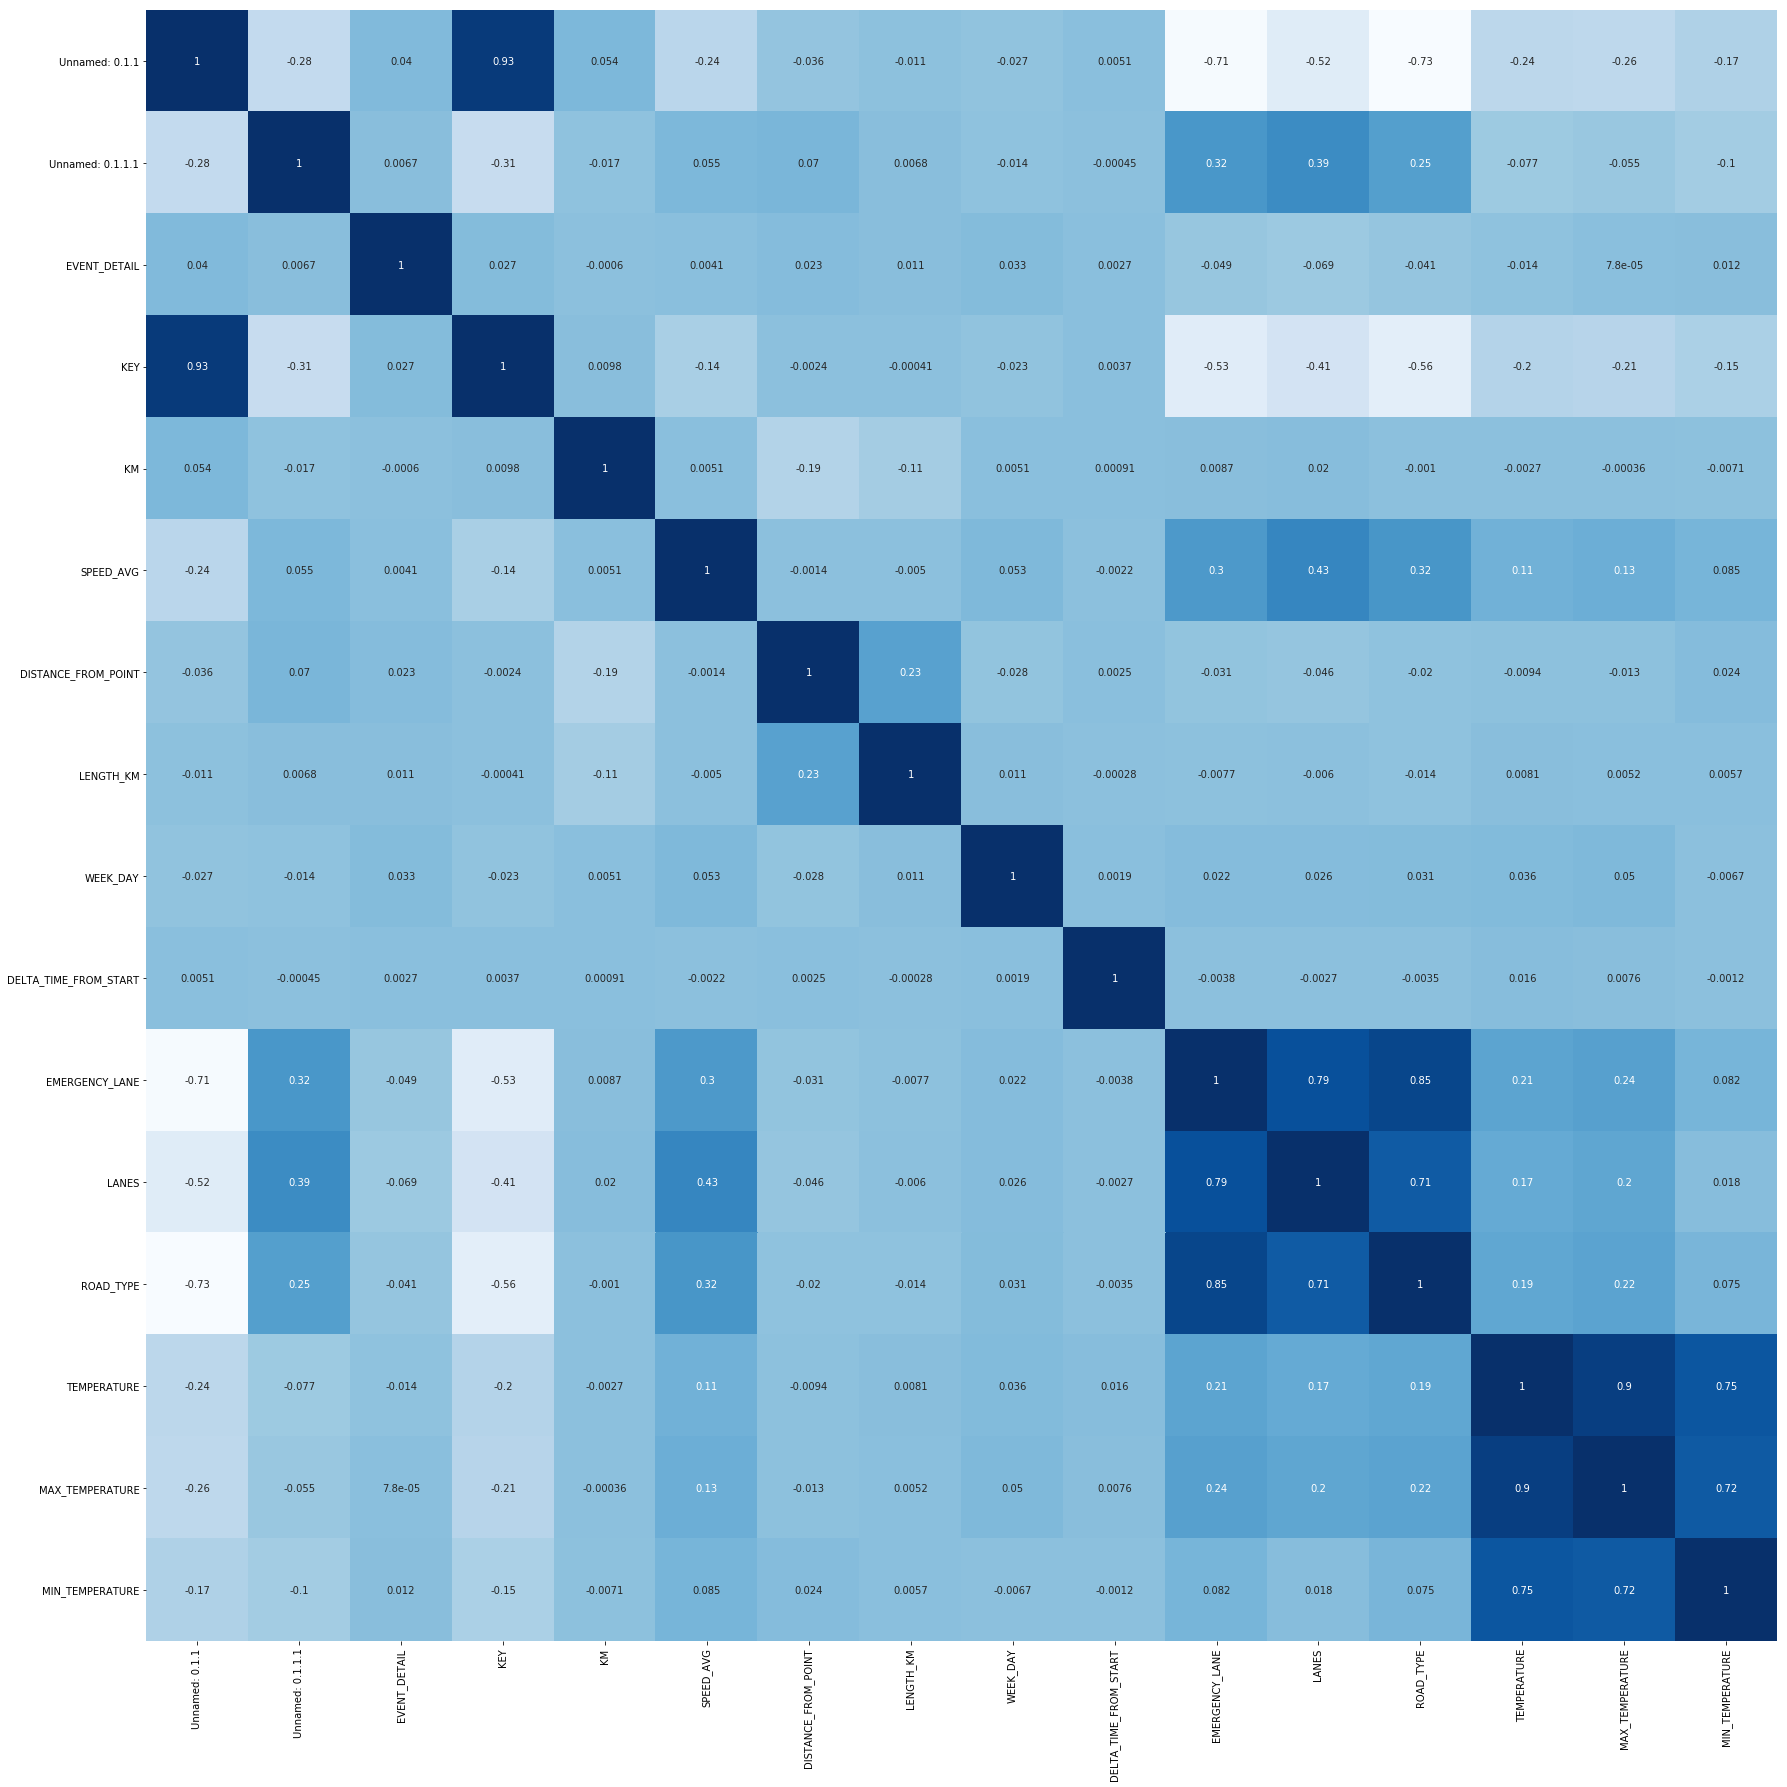

In [23]:
#Correlation matrix
cov=df.corr(method='pearson')
plt.figure(figsize = (30,30))
sns.heatmap(cov,square=True,annot=True,cmap="Blues",cbar=False,xticklabels=True, yticklabels=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1bc2f908>,
      dtype=object)

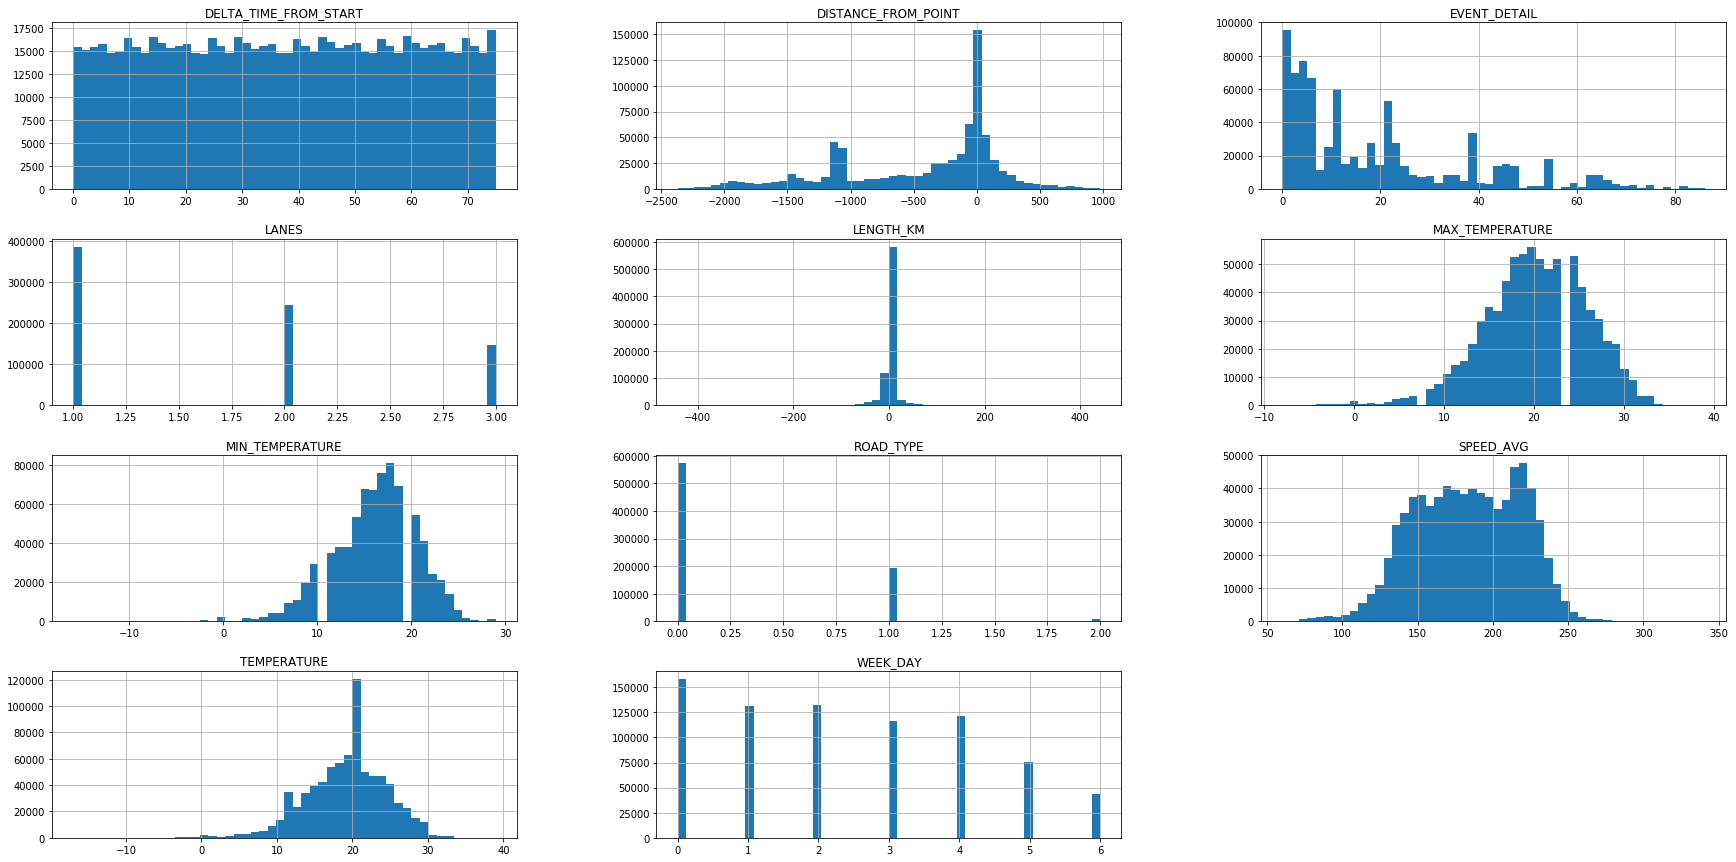

In [24]:
#istogrammi per vedere la distribuzione dei valori numerici
valori = ['DELTA_TIME_FROM_START','DISTANCE_FROM_POINT','EVENT_DETAIL','LENGTH_KM','MAX_TEMPERATURE', 'MIN_TEMPERATURE','LANES','WEEK_DAY','ROAD_TYPE', 'TEMPERATURE','SPEED_AVG']
df[list(valori)].hist(bins = 50, figsize=(30,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c196828>,
      dtype=object)

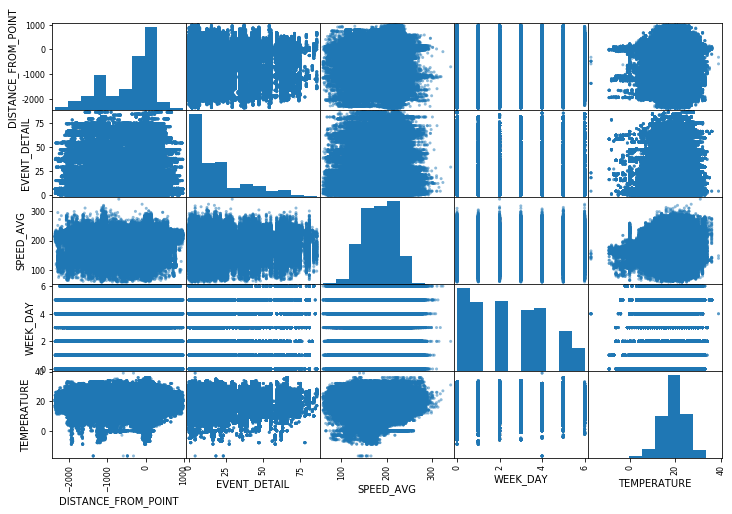

In [33]:
#Scatter matrix di alcuni valori per vedere se c'è una qualche correlazione con la target var
attributes = ['DISTANCE_FROM_POINT','EVENT_DETAIL','SPEED_AVG','WEEK_DAY','TEMPERATURE']
scatter_matrix(df[attributes], figsize = (12,8))

In [26]:
#one-hot encoding delle var categoriche
catOneHot_col = []
for i in cat_col:
    one_hot = pd.get_dummies(df[i])
    one_hot2 = pd.get_dummies(test[i])
    df = df.drop(i,axis = 1)
    test = test.drop(i,axis = 1)
    catOneHot_col.extend(one_hot.columns)
    df = df.join(one_hot)
    test = test.join(one_hot2)
df.columns    

Index(['Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'EVENT_DETAIL', 'KEY',
       'DATETIME_UTC', 'KM', 'SPEED_AVG', 'DISTANCE_FROM_POINT', 'LENGTH_KM',
       'WEEK_DAY', 'DELTA_TIME_FROM_START', 'EMERGENCY_LANE', 'LANES',
       'ROAD_TYPE', 'TEMPERATURE', 'MAX_TEMPERATURE', 'MIN_TEMPERATURE',
       'Allarme', 'Barriere', 'Calamita_naturale', 'Gestione_viabilita',
       'Manutenzione_opere_in_verde', 'Meteo', 'Opera_arte',
       'Ostacolo_in_carreggiata', 'Pavimentazione', 'Regimazione_delle_acque',
       'Segnaletica_orizzontale', 'Segnaletica_verticale', 'Veicolo_in_avaria',
       'extended_accident', 'DebolePioggia', 'FortePioggia', 'Foschia', 'Fumo',
       'Neve', 'QuasiSereno', 'Afternoon', 'EarlyMorning', 'Evening',
       'LateEvening', 'LateMorning', 'Night'],
      dtype='object')

In [27]:
features = list(num_col) + list(catOneHot_col)

In [ ]:
#prova di performance + feature selection con random forest

#X = df[features]
#y = df['SPEED_AVG']
#forest = ExtraTreesRegressor(n_estimators=750, random_state=0, bootstrap=True,criterion='mae', oob_score = True)
#forest.fit(X, y)

In [ ]:
#punteggio out of bag

#forest.oob_score_

In [ ]:
#plot dell'importanza delle feature nel training del random forest

#importances = forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#             axis=0)
#indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(15):
#    print("%d. feature %d %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
#plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="b", yerr=std[indices], align="center")

#plt.xlim([-1, X.shape[1]])
#plt.show()

In [28]:
#prova con xgboost e crossvalidation
x_train = df[list(features)].values
y_train = df["SPEED_AVG"].values

gb = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:gamma',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


#Nel caso si voglia usare la Cross Validation
#xgb_param = gb.get_xgb_params()
#xgtrain = xgb.DMatrix(df[features].values, label=df['SPEED_AVG'].values)
#cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=gb.get_params()['n_estimators'], nfold=10, metrics='mae', early_stopping_rounds=50)
#gb.set_params(n_estimators=cvresult.shape[0])
    
   
gb.fit(x_train, y_train,eval_metric='mae')
        
    

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [29]:
#funzione per visualizzare il MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
#si prendono le features e la target variable dal dataset di test
x_test = test[list(features)].values
y_test = test["SPEED_AVG"].values

In [31]:
#cvresult.tail(10)

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
990,8.337209,0.014347,8.488015,0.035968
991,8.335207,0.014760,8.486156,0.036715
992,8.333763,0.014850,8.484818,0.036717
993,8.332314,0.014986,8.483681,0.036938
994,8.330956,0.015019,8.482518,0.037093
995,8.329511,0.014980,8.481249,0.037221
996,8.328512,0.015232,8.480409,0.036964
997,8.326665,0.015259,8.478525,0.036195
998,8.324775,0.014612,8.476748,0.035725
999,8.322654,0.014307,8.474641,0.035365


In [32]:
#visualizza punteggi sul Training set, test set + media della Cross validation
predictions = gb.predict(x_train)        
predictionsT = gb.predict(x_test)

print ("MAE Score (Train): %f" % mean_absolute_error(y_train,predictions))
print ('MAE Score (Test): %f' % mean_absolute_error(y_test, predictionsT))
#print("MAE Score (CV): %f" % cvresult['test-mae-mean'].tail(1))

print ("MAPE Score (Train): %f" % mean_absolute_percentage_error(y_train,predictions))
print ("MAPE Score (Test): %f" % mean_absolute_percentage_error(y_test,predictionsT))

print ("R2 Score (Train): %f" % r2_score(y_train,predictions))
print ("R2 Score (Test): %f" % r2_score(y_test,predictionsT))

MAE Score (Train): 8.348822
MAE Score (Test): 10.814380
MAE Score (CV): 8.474641
MAPE Score (Train): 5.062673
MAPE Score (Test): 6.290854
R2 Score (Train): 0.863480
R2 Score (Test): 0.763991


In [ ]:
#snippet per joinare la colonna dei risultati al dataset
#df = df.join(predictions)

In [ ]:
#snippet per generare il csv finale
#cols=['','', '']


#output = test[cols]
#output = output.groupby('').sum()
#output.to_csv('RS.csv')